In [1]:
import pandas as pd
import numpy as np
import os
import shutil
import cv2
from keras.preprocessing.image import img_to_array, load_img,apply_affine_transform
from sklearn.model_selection import train_test_split as tts
import tensorflow as tf
from imblearn.under_sampling import RandomUnderSampler
from PIL import Image, ImageChops
from skimage import exposure
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
data_directory = 'C:\\Users\\91902\\Downloads\\NA\\Simplilearn\\Projects\\Advanced Deep learning\\Diabetic-Retinopathy\\DR\\datasetcrop'
csv_path = 'C:\\Users\\91902\\Downloads\\NA\\Simplilearn\\Projects\\Advanced Deep learning\\Diabetic-Retinopathy\\DR\\trainLabels.csv'

In [3]:
df = pd.read_csv(csv_path)
df.head()

,image,level
0,84_left,0
1,84_right,0
2,95_left,0
3,95_right,0
4,99_left,3


In [4]:
df.shape

(1427, 2)

In [5]:
df.level.value_counts()

0    1016
2     230
1     113
4      36
3      32
Name: level, dtype: int64

<BarContainer object of 5 artists>

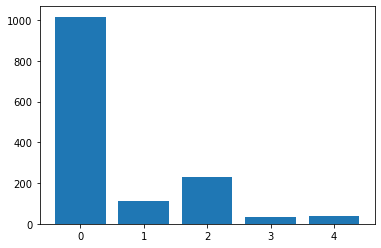

In [6]:
plt.bar(df.level.value_counts().index,df.level.value_counts())

As it can be seen that dataset is highly imbalanced. We do the following steps to get a balanced dataset:

1. Merge class 3 and class 4 to a mean a "Severe DR", givig a total of 68 images
2. Rotate all the images in the new class by 90 and 180 degrees, giving us an extra 136 images, making the total count of 204 images
3. Flip each of 204 images vertically, making the total of 408 images
4. Shear each of 408 images, giving us a total of 816 images
5. Rotate all images in class 1 by 90 degrees, giving a total count of 226 images, call it "Mild DR"
6. Flip and shear all images in class 1, giving a total of 904 images
7. Flip and shear all images in class 2, getting total of 920 images, call it "Moderate DR"
8. Undersample class 0 to get a total of 900 images, call it "No DR" 

In [7]:
DR_STAGE_ZERO = "No DR"
DR_STAGE_MILD = "Mild DR"
DR_STAGE_MODERATE = "Moderate DR"
DR_STAGE_SEVERE = "Severe DR"

In [8]:
df['image_extensions'] = df.image.apply(lambda x: x + '.jpeg' )

In [9]:
def new_level(s):
    if s==0:
        return DR_STAGE_ZERO
    elif s==1:
        return DR_STAGE_MILD
    elif s==2:
        return DR_STAGE_MODERATE
    else:
        return DR_STAGE_SEVERE

In [10]:
df['new_level'] = df.level.apply(new_level)

In [11]:
df = df.drop(columns=['image','level'])

### Cropping images

In [12]:
def trim(im):
    """Crops images such that the black portion is removed
    """
    bg = Image.new(im.mode, im.size, im.getpixel((0,0)))
    diff = ImageChops.difference(im, bg)
    diff = ImageChops.add(diff, diff, 0.5, -100)
    #Bounding box given as a 4-tuple defining the left, upper, right, and lower pixel 
    #coordinates.
    #If the image is completely empty, this method returns None.
    bbox = diff.getbbox()
    if bbox:
        return im.crop(bbox)

In [13]:
def crop_images(dir_name):
    """takes a directory of images, crops all the images to remove black portion and
    overwrites the files. 
    """
    for imagename in os.listdir(dir_name):
        imagepath = os.path.join(dir_name, imagename)
        image = Image.open(imagepath)
        cropped = trim(image)
        cropped.save(imagepath)

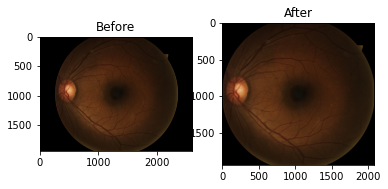

In [14]:
cropimg = Image.open(r'C:\Users\91902\Downloads\NA\Simplilearn\Projects\Advanced Deep learning\Diabetic-Retinopathy\84_left.jpeg')
croppedimg = trim(cropimg)
plt.subplot(121)
plt.title("Before")
plt.imshow(cropimg)
plt.subplot(122)
plt.title("After")
plt.imshow(croppedimg)

In [15]:
def crop_required():
    """ User discretion on whether images need to be cropped
    """
    crop_required = input("Is cropping required?(Y/N)")
    if(crop_required.lower()=='y'):
        return True
    else:
        return False

In [16]:
if(crop_required()):
    print("Cropping images to remove the black portion")
    crop_images(data_directory)    
else:
    print("Images already cropped")

Is cropping required?(Y/N) N


Images already cropped


### Resizing images

In [17]:
dim = (512,512)

In [18]:
def resize_images(dir_name, dim):
    """ Takes a directory{dir_name} of images, resizes all the images to {dimXdim} 
    dimension and creates and returns a new directory with dimension suffixed.
    """
    new_dir = get_resized_directory(dir_name, dim) 
    if not (os.path.isdir(new_dir)):
        os.makedirs(new_dir)
    for image in os.listdir(dir_name):
        imagepath = os.path.join(dir_name,image)
        imagepathtarget = os.path.join(new_dir,image)
        try:
            img = cv2.imread(imagepath, cv2.COLOR_BGR2RGB)
            img = img_to_array(img)
            if(img.shape == dim + (3,)):
                pass
            else:
                resized = cv2.resize(img,dim, cv2.INTER_LINEAR)
                cv2.imwrite(imagepathtarget,resized)
        except IOError:
            print(f"{image} Not an image")
            
    return new_dir

In [19]:
def resize_required(dir_path, dim):
    folder_name = os.path.basename(dir_path)
    parent_dir = os.path.dirname(dir_path)
    resized_folder = folder_name + str(dim[0])
    return not (resized_folder in os.listdir(parent_dir))

In [20]:
def get_resized_directory(dir_name, dim):
    return dir_name + str(dim[0])

In [21]:
if(resize_required(data_directory,dim)):
    print("resize required. creating new directory and resizing....")
    resize_images(data_directory,dim)
else:
    print("Images already resized") 

Images already resized


In [22]:
#shift the working directory to resized directory
data_directory = get_resized_directory(data_directory,dim)

## Data Augmentation

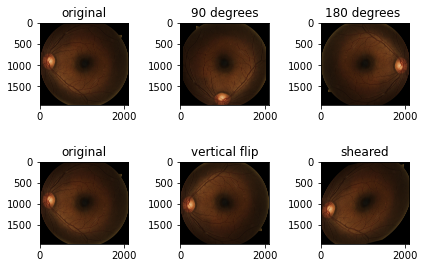

In [24]:
img = Image.open(r'C:\\Users\\91902\\Downloads\\NA\\Simplilearn\\Projects\\Advanced Deep learning\\Diabetic-Retinopathy\\DR\\datasetcrop\\84_left.jpeg')
imgmatrix = np.asarray(img)
rotate_img = img.rotate(90)
rotate_img1 = img.rotate(180)
flippedimg = cv2.flip(imgmatrix,0)
shearedimg = apply_affine_transform(imgmatrix,shear=-15,fill_mode='constant')
plt.subplot(231)
plt.title("original")
plt.imshow(img)
plt.subplot(232)
plt.title("90 degrees")
plt.imshow(rotate_img)
plt.subplot(233)
plt.title("180 degrees ")
plt.imshow(rotate_img1)
plt.subplot(234)
plt.title("original")
plt.imshow(img)
plt.subplot(235)
plt.title("vertical flip")
plt.imshow(flippedimg)
plt.subplot(236)
plt.title("sheared")
plt.imshow(shearedimg)
plt.tight_layout()

In [25]:
def match_data(dir_path):
    """Removes image files which are not present in csv, and removes rows of dataframe 
        which are not present as images in the dataset
    """
    files = os.listdir(dir_path)
    global df
    setA = set(df['image_extensions'].tolist())
    setB = set(files)
    diff = setA.symmetric_difference(setB)
    for item in diff:
        if(item in setA):
            df = df[df['image_extensions']!=item]
        else:
            os.remove(os.path.join(dir_path,item))
         

In [26]:
match_data(data_directory)

In [27]:
def rotate_images_for_class(dir_name,level,*angles):
    imglist = os.listdir(dir_name)
    global df
    imglistdf = (df[df['new_level']==level])['image_extensions'].tolist()
    print()
    row_list = []
    for image in imglistdf:
        imgpath = os.path.join(dir_name,image)
        img = Image.open(imgpath)
        imgname = image.split('.')[0]
        
        for angle in angles:
            imgrotate = img.rotate(angle)
            newname = imgname + str(angle) + '.jpeg'
            imgrotate.save(os.path.join(dir_name,newname))
            ## add to list to save into df
            row = {}
            row['image_extensions'] = newname
            row['new_level'] = level
            row_list.append(row)
    #add to df  
   
    newimgdf = pd.DataFrame(row_list)
    df = pd.concat([df,newimgdf], axis=0)
    

In [28]:
def shear_image_for_class(dir_name,level,shear):
    imglist = os.listdir(dir_name)
    global df
    imglistdf = (df[df['new_level']==level])['image_extensions'].tolist()
    print()
    row_list = []
    for image in imglistdf:
        imgpath = os.path.join(dir_name,image)
        img = Image.open(imgpath)
        imgname = image.split('.')[0]
        imgmatrix = np.asarray(img)
        
        imgshearmatrix = apply_affine_transform(x=imgmatrix, shear=shear, fill_mode='constant')
        shearedimage = Image.fromarray(imgshearmatrix)
        newname = imgname + "_sheared" + '.jpeg'
        shearedimage.save(os.path.join(dir_name,newname))
        row = {}
        row['image_extensions'] = newname
        row['new_level'] = level
        row_list.append(row)
    #add to df  
   
    newimgdf = pd.DataFrame(row_list)
    df = pd.concat([df,newimgdf], axis=0)
    
    

In [29]:
def flip_image_vertically_for_class(dir_name,level):
    imglist = os.listdir(dir_name)
    global df
    imglistdf = (df[df['new_level']==level])['image_extensions'].tolist()
    print()
    row_list = []
    for image in imglistdf:
        imgpath = os.path.join(dir_name,image)
        img = Image.open(imgpath)
        imgname = image.split('.')[0]
        imgmatrix = np.asarray(img)
        flippedimagematrix = cv2.flip(imgmatrix,0)
        newname = imgname + "_flipped" + '.jpeg'
        flippedimage = Image.fromarray(flippedimagematrix)
        flippedimage.save(os.path.join(dir_name,newname))
        row = {}
        row['image_extensions'] = newname
        row['new_level'] = level
        row_list.append(row)
    #add to df  
   
    newimgdf = pd.DataFrame(row_list)
    df = pd.concat([df,newimgdf], axis=0)
    

In [30]:
def augmentdata(dir_name):
    
    rotate_images_for_class(dir_name, DR_STAGE_SEVERE,90,180)
    flip_image_vertically_for_class(dir_name,DR_STAGE_SEVERE)
    shear_image_for_class(dir_name,DR_STAGE_SEVERE,15)
    
    rotate_images_for_class(dir_name, DR_STAGE_MILD, 90)
    flip_image_vertically_for_class(dir_name,DR_STAGE_MILD)
    shear_image_for_class(dir_name,DR_STAGE_MILD,15)
    
    flip_image_vertically_for_class(dir_name,DR_STAGE_MODERATE)
    shear_image_for_class(dir_name,DR_STAGE_MODERATE,15)

In [31]:
def augrequired():
    augrequired = input("Augmentation required?(Y/N)")
    if(augrequired.lower()=='y'):
        return True
    else:
        return False

In [34]:
if(augrequired()):
    print("augmenting images...")
    augmentdata(data_directory)
else:
    print("Images already augmented")

Augmentation required?(Y/N) Y


augmenting images...










In [35]:
df.new_level.value_counts()

No DR          1016
Moderate DR     920
Mild DR         896
Severe DR       816
Name: new_level, dtype: int64

### Histogram Equalization

In [36]:
def histogram_equalization(dir_name):
    """ Takes a directory of images and applies histogram equalization to each image
    and overwrites
    """
    for image in os.listdir(dir_name):
        impath = os.path.join(dir_name,image)
        im = cv2.imread(impath)
        rgb = cv2.cvtColor(im,cv2.COLOR_BGR2RGB)
        imgarray = img_to_array(rgb)
        img_eq = exposure.equalize_hist(imgarray)
        plt.imsave(impath,img_eq)

In [37]:
def equalization_required():
    """A function which takes user input on whether to apply histogram equalization 
    on the working directory of images
    """
    equalization_required = input("Is equalization required?(Y/N)")
    if(equalization_required.lower()=='y'):
        return True
    else:
        return False

In [38]:
if(equalization_required()):
    print("Applying Histogram Equalization..")
    histogram_equalization(data_directory)
    print("Done")
else:
    print("Equalization already applied")

Is equalization required?(Y/N) N


Equalization already applied


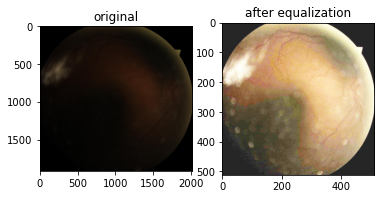

In [39]:
originalimage = Image.open(r'C:\Users\91902\Downloads\NA\Simplilearn\Projects\Advanced Deep learning\Diabetic-Retinopathy\DR\datasetcrop\8744_right.jpeg')
aftereq = Image.open(r'C:\Users\91902\Downloads\NA\Simplilearn\Projects\Advanced Deep learning\Diabetic-Retinopathy\DR\datasetcrop512\8744_right.jpeg')
plt.subplot(121)
plt.title("original")
plt.imshow(originalimage)
plt.subplot(122)
plt.title("after equalization")
plt.imshow(aftereq)

### Undersampling and balancing the training set

In [40]:
X = df.drop(columns=['new_level'])
y = df['new_level']

In [41]:
def undersampler(X,y,class_numbers):
    """uses RandomUnderSampler to undersample the data
    """
    undersampler = RandomUnderSampler(sampling_strategy=class_numbers)
    X_,y_ = undersampler.fit_resample(X,y)
    return X_,y_

In [42]:
bal_size = y.value_counts().min()

In [43]:
classes = [DR_STAGE_ZERO, DR_STAGE_MILD, DR_STAGE_MODERATE, DR_STAGE_SEVERE]
class_numbers = {}
for clas in classes :
    class_numbers[clas] = bal_size
print(class_numbers)

{'No DR': 816, 'Mild DR': 816, 'Moderate DR': 816, 'Severe DR': 816}


In [44]:
X_under,y_under = undersampler(X,y,class_numbers)

### Train - Test Split

In [45]:
#method to split the dataset into training and testing set
def train_test_split(path, X,y, test_size = 0.25,random_state=10):
    
    """ path = path to the directory which contains all the images
    test_size = proportion of the dataset to be kept for testing
    creates two new directories named train and test into the path of data directory
    copies the images from the data directory into train and test after splitting and deletes original file. 
    """  
    X_train, X_test, y_train, y_test = tts(X,y,test_size=test_size,random_state = random_state, stratify = y)
    
    files = os.listdir(path)
    train_filename_path_src = \
    [os.path.join(path, image) for image in X_train['image_extensions'].tolist() if image in files]
    test_filename_path_src = \
    [os.path.join(path, image) for image in X_test['image_extensions'].tolist() if image in files]
    
    path_train_dir = os.path.join(path,"train")
    path_test_dir = os.path.join(path,"test")
      
    #always true
    if not os.path.exists(path_train_dir):
        os.makedirs(path_train_dir)    
    if not os.path.exists(path_test_dir):
        os.makedirs(path_test_dir)

    for image in train_filename_path_src:        
        shutil.copy(image, path_train_dir)
    for image in test_filename_path_src:
        shutil.copy(image, path_test_dir)  
        
    return X_train, X_test, y_train, y_test

In [46]:
def split_required(dir_path):
    folders = os.listdir(dir_path)
    if("train" in folders and "test" in folders):
        return False
    return True    
    

In [47]:
#if(split_required(data_directory)):
print(f"split required at {data_directory}, splitting...")
X_train, X_test, y_train, y_test = train_test_split(data_directory,X_under,y_under,0.30,100)
#else:
#print("data already splitted")

split required at C:\Users\91902\Downloads\NA\Simplilearn\Projects\Advanced Deep learning\Diabetic-Retinopathy\DR\datasetcrop512, splitting...


### Segregating images to class directories

In [48]:
def class_segregation(dir_path,X,y):
    """ takes a given folder and splits it into respective classes based on the csv 
    file labels mapped to the names of the files
    dir_path = path of the directory which needs to be segmented
    classes = list of classes present in the dataset, as string
    """
    #Issue: Delete existing folders if any. 
    
    image_list = os.listdir(dir_path)
    classes = get_classes(y)
    X['new_level'] = y
    
    for clas in classes:
        os.makedirs(os.path.join(dir_path,clas))
    
    for image in image_list:
        if(image in X['image_extensions'].tolist()):
            label = (X[X['image_extensions']==image]['new_level']).tolist()[0]
            image_path_src = os.path.join(dir_path, image)
            dest = os.path.join(dir_path, str(label))
            image_path_dest = os.path.join(dest,image)
            shutil.move(image_path_src, image_path_dest)

In [49]:
def segregation_required(dir_path):
    all_files = os.listdir(dir_path)
    directories = [x for x in all_files if os.path.isdir(os.path.join(dir_path,x))]
    print(directories)
    if not directories:
        return True
    for folder in directories:
        if folder not in classes :
            return True
    return False

In [50]:
def get_classes(target):
    return [str(x) for x in target.value_counts().index.tolist()]
    

In [51]:
train_path = os.path.join(data_directory,"train")
test_path = os.path.join(data_directory,"test")

if(segregation_required(train_path)):
    print(f"class segregation required at {train_path}, segmenting...")
    class_segregation(train_path,X_under,y_under)
else:
    print("train data already segmented")
    
if(segregation_required(test_path)):
    print(f"class segregation required at {test_path}, segmenting...")
    class_segregation(test_path,X_test,y_test)
else:
    print("test data already segmented")


[]
class segregation required at C:\Users\91902\Downloads\NA\Simplilearn\Projects\Advanced Deep learning\Diabetic-Retinopathy\DR\datasetcrop512\train, segmenting...
[]
class segregation required at C:\Users\91902\Downloads\NA\Simplilearn\Projects\Advanced Deep learning\Diabetic-Retinopathy\DR\datasetcrop512\test, segmenting...


<ipython-input-48-5d0ae1edd9a0>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['new_level'] = y


In [45]:
def rmvfiles(flow_dir):
    for x in os.listdir(flow_dir):
        file = os.path.join(flow_dir,x)
        if os.path.isfile(file):
            os.remove(file)
    

In [46]:
rmvfiles(train_path)

### Model Building

In [52]:
import keras
import tensorflow
from keras.preprocessing.image import load_img, img_to_array
from keras.models import Sequential
from keras.layers import Dense, Flatten, BatchNormalization, Dropout
from keras.layers.convolutional import Conv2D,MaxPooling2D
from keras.metrics import Precision, Recall
from livelossplot import PlotLossesKeras
from tensorflow.keras.optimizers import SGD

In [48]:
epochs = 50
learning_rate = 0.1
decay_rate = learning_rate / epochs

In [53]:
model = Sequential()

model.add(Conv2D(32,kernel_size = (3,3), activation = 'relu', input_shape=(512,512,3)))
model.add(MaxPooling2D(pool_size=(2,2), strides = (2,2)))
model.add(BatchNormalization())

model.add(Conv2D(32,kernel_size = (3,3), activation = 'relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides = (2,2)))
model.add(BatchNormalization())

model.add(Conv2D(64,kernel_size = (3,3), activation = 'relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides = (2,2)))
model.add(BatchNormalization())

model.add(Conv2D(64,kernel_size = (3,3), activation = 'relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides = (2,2)))
model.add(BatchNormalization())

model.add(Conv2D(128,kernel_size = (3,3), activation = 'relu'))
# model.add(MaxPooling2D(pool_size=(2,2), strides = (2,2)))
# model.add(BatchNormalization())

model.add(Conv2D(128,kernel_size = (3,3), activation = 'relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides = (2,2)))
model.add(BatchNormalization())

model.add(Conv2D(256,kernel_size = (3,3), activation = 'relu'))

model.add(Conv2D(256,kernel_size = (3,3), activation = 'relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides = (2,2)))
model.add(BatchNormalization())

model.add(Conv2D(512,kernel_size = (3,3), activation = 'relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides = (2,2)))  
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Flatten())          
model.add(Dense(1024,activation='relu'))  
model.add(Dropout(0.5))
model.add(Dense(1024,activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(4,activation='softmax'))
model.compile(loss='categorical_crossentropy',metrics=['accuracy', Precision(), Recall()],optimizer=SGD(learning_rate=0.001))


In [54]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 510, 510, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 255, 255, 32)      0         
_________________________________________________________________
batch_normalization (BatchNo (None, 255, 255, 32)      128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 253, 253, 32)      9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 126, 126, 32)      0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 126, 126, 32)      128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 124, 124, 64)      1

In [55]:
from keras.preprocessing.image import ImageDataGenerator

In [56]:
train_datagen = ImageDataGenerator(rescale = 1/255.)
test_datagen = ImageDataGenerator(rescale = 1/255.)

In [57]:
batch_size = 32

In [58]:
train_generator = train_datagen.flow_from_directory(train_path, target_size=dim, batch_size=batch_size, shuffle=True, class_mode='categorical')
test_generator = test_datagen.flow_from_directory(test_path, target_size=dim, batch_size=batch_size, class_mode='categorical')

Found 2284 images belonging to 4 classes.
Found 980 images belonging to 4 classes.


In [59]:
stepsPerEpoch = 2284//batch_size

In [60]:
from keras.callbacks import ModelCheckpoint
filepath = 'weights_best_model2_10.hdf5'
checkpoint = ModelCheckpoint(filepath,monitor = 'val_accuracy',verbose = 1, save_best_only=True, mode='max')

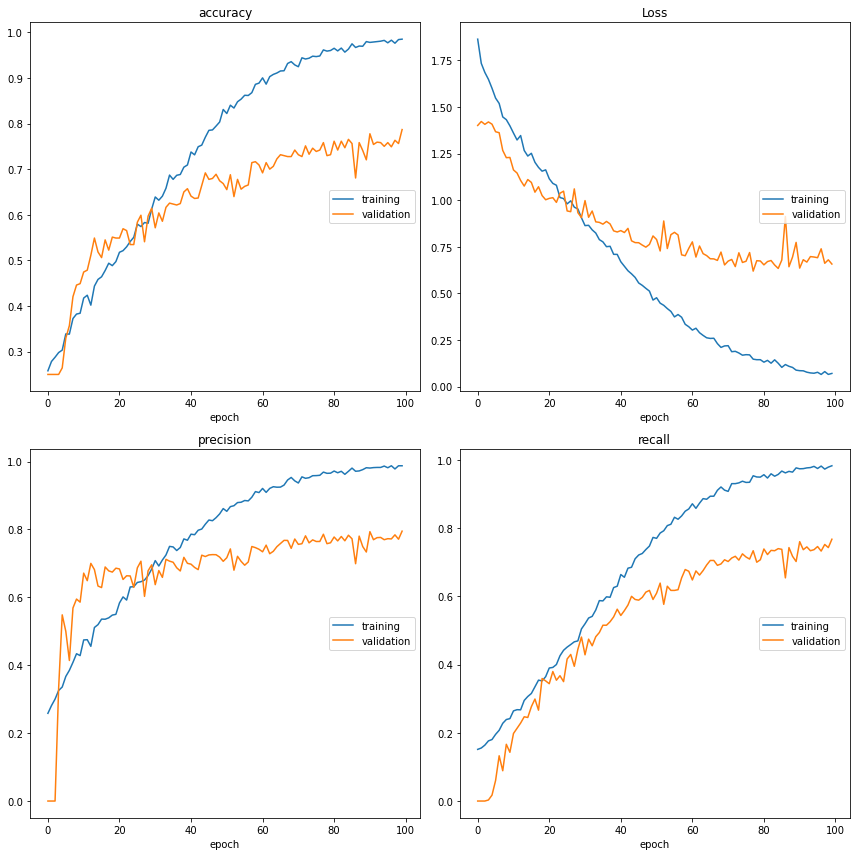

accuracy
	training         	 (min:    0.258, max:    0.985, cur:    0.985)
	validation       	 (min:    0.250, max:    0.787, cur:    0.787)
Loss
	training         	 (min:    0.065, max:    1.863, cur:    0.070)
	validation       	 (min:    0.619, max:    1.422, cur:    0.657)
precision
	training         	 (min:    0.258, max:    0.988, cur:    0.988)
	validation       	 (min:    0.000, max:    0.795, cur:    0.795)
recall
	training         	 (min:    0.151, max:    0.983, cur:    0.983)
	validation       	 (min:    0.000, max:    0.767, cur:    0.767)

Epoch 00100: val_accuracy improved from 0.77755 to 0.78673, saving model to weights_best_model2_10.hdf5


In [61]:
history = model.fit(train_generator, steps_per_epoch = stepsPerEpoch,
           epochs = 100, validation_data=test_generator,
           callbacks = [ PlotLossesKeras(),checkpoint])  

In [62]:
model.save("./DR/model2_10")

INFO:tensorflow:Assets written to: ./DR/model2_10\assets


Note this model doesn't have the capacity to overfit. 

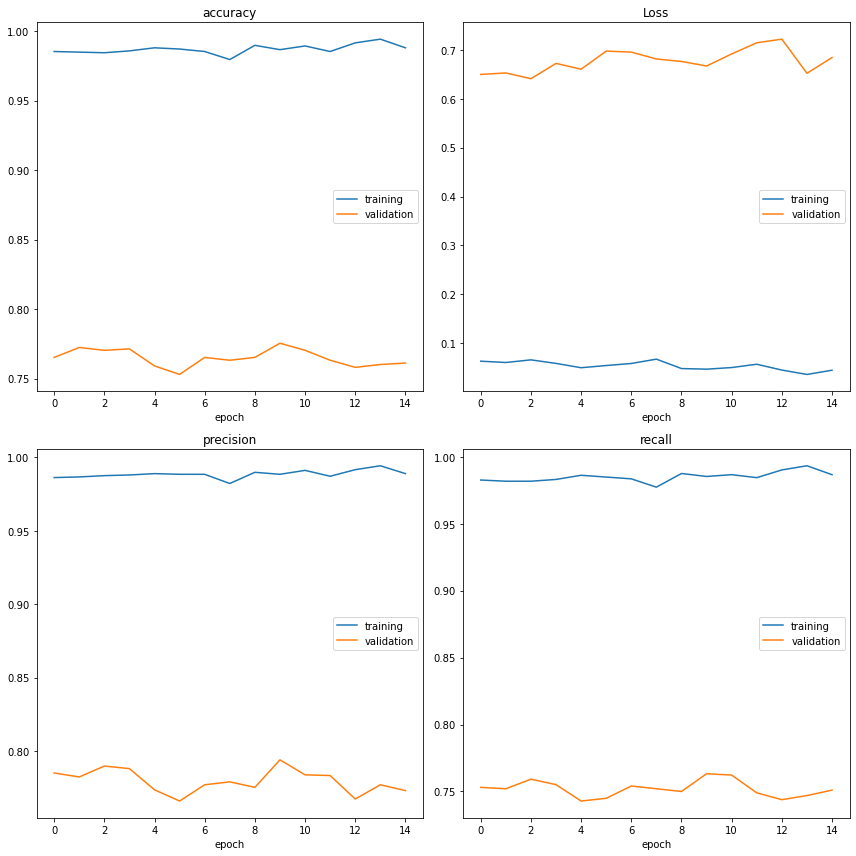

accuracy
	training         	 (min:    0.980, max:    0.994, cur:    0.988)
	validation       	 (min:    0.753, max:    0.776, cur:    0.761)
Loss
	training         	 (min:    0.036, max:    0.067, cur:    0.045)
	validation       	 (min:    0.641, max:    0.722, cur:    0.684)
precision
	training         	 (min:    0.982, max:    0.994, cur:    0.989)
	validation       	 (min:    0.766, max:    0.794, cur:    0.773)
recall
	training         	 (min:    0.977, max:    0.993, cur:    0.987)
	validation       	 (min:    0.743, max:    0.763, cur:    0.751)

Epoch 00015: val_accuracy did not improve from 0.78673


In [63]:
history_continued = model.fit(train_generator, steps_per_epoch = stepsPerEpoch,
           epochs = 15, validation_data=test_generator,
           callbacks = [ PlotLossesKeras(),checkpoint])  

In [64]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

In [65]:
test_generator.shuffle =False

In [69]:
model.load_weights(filepath)

In [70]:
test_steps_per_epoch = np.math.ceil(test_generator.samples / test_generator.batch_size)
predictions = model.predict(test_generator, steps=test_steps_per_epoch)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())  
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report)

              precision    recall  f1-score   support

     Mild DR       0.84      0.81      0.83       245
 Moderate DR       0.77      0.70      0.74       245
       No DR       0.70      0.76      0.73       245
   Severe DR       0.83      0.88      0.85       245

    accuracy                           0.79       980
   macro avg       0.79      0.79      0.79       980
weighted avg       0.79      0.79      0.79       980



In [71]:
print(confusion_matrix(test_generator.classes, predicted_classes))

[[198  16  21  10]
 [ 17 172  43  13]
 [ 11  27 186  21]
 [  9   7  14 215]]


## Latent Representation of DR images, compared with T-SNE

In [1]:
import random
import os
import cv2
import numpy as np

In [2]:

def img_to_array_data(dir_path, classes):
    data_array = []
    for clas in classes:
        classpath = os.path.join(dir_path,str(clas))
        for img in os.listdir(classpath):
            img_array = cv2.imread(os.path.join(classpath,img))
            data_array.append([img_array,clas])    
    
    X =[]
    y =[]

    for features, label in data_array:
        X.append(features)
        y.append(label)
        
    X = np.array(X).reshape(len(X),-1)
    X = X.astype('float32')
    X /= 255
    Y = y
    
    return X,Y

    

In [3]:
data_orig = r"C:\Users\91902\Downloads\NA\Simplilearn\Projects\Advanced Deep learning\New folder\datasetcrop512\train"
classes_orig = [0,1,2,3,4]

In [4]:
X_vis, y_vis = img_to_array_data(data_orig,classes_orig)

In [5]:
X_vis.shape

(1426, 786432)

In [6]:
from sklearn.manifold import TSNE

In [7]:
tsne = TSNE(n_components=2, random_state=0)
    
X_t = tsne.fit_transform(X_vis)

In [8]:
y_vis = np.array(y_vis)

In [9]:
np.unique(y_vis)

array([0, 1, 2, 3, 4])

In [10]:
import matplotlib.pyplot as plt

In [11]:
def tsneplot(X,Y):
    colors = ['g','r','b','darkorange','m']
    plt.figure(figsize=(12, 8))
    for i in np.unique(Y):
        plt.scatter(X[np.where(Y==i),0],
                    X[np.where(Y==i),1],
                    marker='o', 
                    color=colors[i], 
                    linewidth=1, 
                    alpha=0.8, 
                    label = f"class{i}")
    
    plt.legend(loc='best')
    plt.savefig("tsne2d")
    plt.show()   
        
    

### T-SNE with 2 dimensions

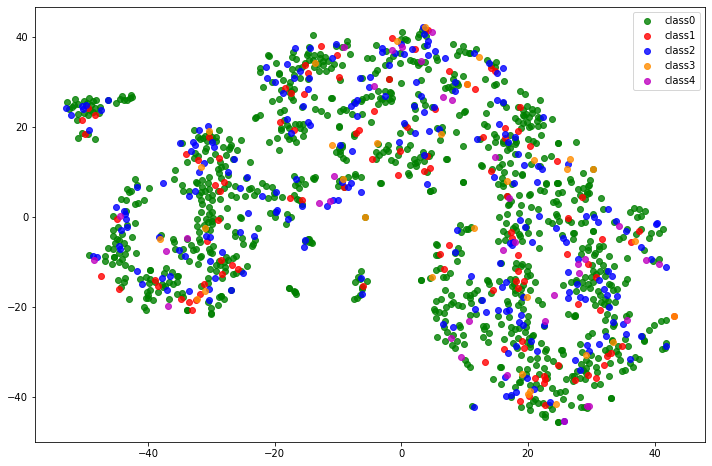

In [12]:
tsneplot(X_t,y_vis)

In [13]:
from Autoencoder import Autoencoder

In [14]:
autoencoder = Autoencoder(input_shape = (512, 512, 3),
                             conv_filters = (32, 64, 64),
                             conv_kernels =  (3,3,3),
                             conv_strides = (2,2,2),
                             latent_space_dim  = 2)

autoencoder.summary()

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   [(None, 512, 512, 3)]     0         
_________________________________________________________________
encoder_conv_layer1 (Conv2D) (None, 256, 256, 32)      896       
_________________________________________________________________
encoder_relu_1 (ReLU)        (None, 256, 256, 32)      0         
_________________________________________________________________
encoder_bn_1 (BatchNormaliza (None, 256, 256, 32)      128       
_________________________________________________________________
encoder_conv_layer2 (Conv2D) (None, 128, 128, 64)      18496     
_________________________________________________________________
encoder_relu_2 (ReLU)        (None, 128, 128, 64)      0         
_________________________________________________________________
encoder_bn_2 (BatchNormaliza (None, 128, 128, 64)      256 

In [15]:
autoencoder.compile(learning_rate=0.001)

In [16]:
X_ae = X_vis.reshape(-1,512,512,3)

In [17]:
import tensorflow as tf
tf.config.run_functions_eagerly(True)

In [18]:
autoencoder.train(X_ae,batch_size=16,num_epochs=10)

C:\Users\91902\anaconda3\lib\site-packages\tensorflow\python\data\ops\dataset_ops.py:4211: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


Epoch 1/10
90/90 [==============================] - 269s 3s/step - loss: 0.0467
Epoch 2/10
90/90 [==============================] - 271s 3s/step - loss: 0.0275
Epoch 3/10
90/90 [==============================] - 274s 3s/step - loss: 0.0253
Epoch 4/10
90/90 [==============================] - 274s 3s/step - loss: 0.0230
Epoch 5/10
90/90 [==============================] - 286s 3s/step - loss: 0.0225
Epoch 6/10
90/90 [==============================] - 298s 3s/step - loss: 0.0218
Epoch 7/10
90/90 [==============================] - 285s 3s/step - loss: 0.0214
Epoch 8/10
90/90 [==============================] - 280s 3s/step - loss: 0.0221
Epoch 9/10
90/90 [==============================] - 280s 3s/step - loss: 0.0214
Epoch 10/10
90/90 [==============================] - 288s 3s/step - loss: 0.0210


In [19]:
from keras.models import Sequential

In [24]:
hidden_representation = autoencoder.encoder
hidden_representation.summary()


Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   [(None, 512, 512, 3)]     0         
_________________________________________________________________
encoder_conv_layer1 (Conv2D) (None, 256, 256, 32)      896       
_________________________________________________________________
encoder_relu_1 (ReLU)        (None, 256, 256, 32)      0         
_________________________________________________________________
encoder_bn_1 (BatchNormaliza (None, 256, 256, 32)      128       
_________________________________________________________________
encoder_conv_layer2 (Conv2D) (None, 128, 128, 64)      18496     
_________________________________________________________________
encoder_relu_2 (ReLU)        (None, 128, 128, 64)      0         
_________________________________________________________________
encoder_bn_2 (BatchNormaliza (None, 128, 128, 64)      256 

In [26]:
Xclass0 = X_ae[np.where(y_vis==0)]

In [28]:
Xclass1 = X_ae[np.where(y_vis==1)]
Xclass2 = X_ae[np.where(y_vis==2)]
Xclass3 = X_ae[np.where(y_vis==3)]
Xclass4 = X_ae[np.where(y_vis==4)]

In [29]:
X0ae = hidden_representation.predict(Xclass0)
X1ae = hidden_representation.predict(Xclass1)
X2ae = hidden_representation.predict(Xclass2)

C:\Users\91902\anaconda3\lib\site-packages\tensorflow\python\data\ops\dataset_ops.py:4211: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


In [30]:
X3ae = hidden_representation.predict(Xclass3)
X4ae = hidden_representation.predict(Xclass4)

C:\Users\91902\anaconda3\lib\site-packages\tensorflow\python\data\ops\dataset_ops.py:4211: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


In [62]:
repx = np.vstack([X0ae,X1ae,X2ae,X3ae,X4ae])

### Latent Representation with bottleneck 2D

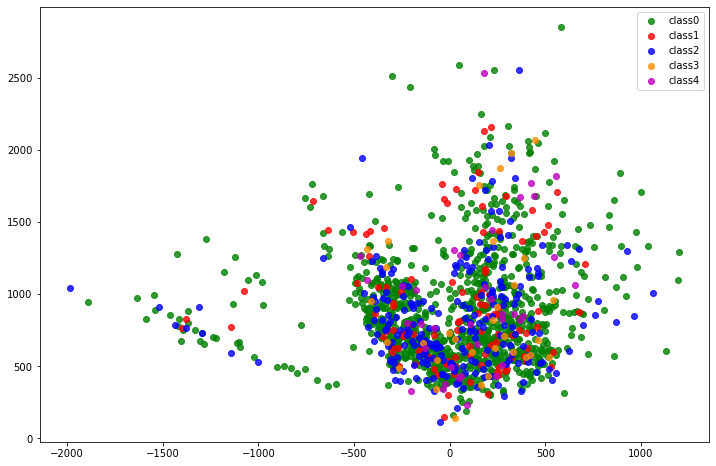

In [63]:
tsneplot(repx,y_vis)

In [86]:
def tsneplot3D(X,Y,name):
    colors = ['g','r','b','darkorange','m']
    plt.figure(figsize=(12, 8))
    ax = plt.axes(projection ="3d")
    for i in np.unique(Y):
        ax.scatter3D(X[np.where(Y==i),0],
                    X[np.where(Y==i),1],
                    X[np.where(Y==i),2],
                    marker='o', 
                    color=colors[i], 
                    linewidth=1, 
                    alpha=0.8, 
                    label = f"class{i}")
    
    plt.legend(loc='best')
    plt.savefig(f"{name}")
    plt.show() 

In [ ]:
tsne3d = TSNE(n_components=3, random_state=0)
    
X_t_3d = tsne3d.fit_transform(X_vis)



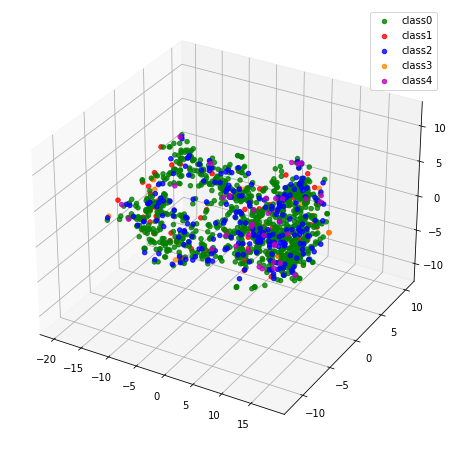

In [72]:
tsneplot3D(X_t_3d,y_vis)

### Autoencoder(Deeper) with Bottleneck 3D and downsample

In [73]:
autoencoder3d = Autoencoder(input_shape = (512, 512, 3),
                             conv_filters = (32, 64, 128,256),
                             conv_kernels =  (3,3,3,3),
                             conv_strides = (2,2,2,2),
                             latent_space_dim  = 3)

autoencoder3d.summary()

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   [(None, 512, 512, 3)]     0         
_________________________________________________________________
encoder_conv_layer1 (Conv2D) (None, 256, 256, 32)      896       
_________________________________________________________________
encoder_relu_1 (ReLU)        (None, 256, 256, 32)      0         
_________________________________________________________________
encoder_bn_1 (BatchNormaliza (None, 256, 256, 32)      128       
_________________________________________________________________
encoder_conv_layer2 (Conv2D) (None, 128, 128, 64)      18496     
_________________________________________________________________
encoder_relu_2 (ReLU)        (None, 128, 128, 64)      0         
_________________________________________________________________
encoder_bn_2 (BatchNormaliza (None, 128, 128, 64)      256 

In [74]:
autoencoder3d.compile(learning_rate=0.001)

In [75]:
X_ae_0 = X_ae[np.where(y_vis==0)]

In [78]:
X_ae_1 = X_ae[np.where(y_vis==1)]
X_ae_2 = X_ae[np.where(y_vis==2)]
X_ae_3 = X_ae[np.where(y_vis==3)]
X_ae_4 = X_ae[np.where(y_vis==4)]

Here we downsample the dataset to be of size 32 images per class

In [79]:
X_ae_0 = X_ae_0[np.random.choice(X_ae_0.shape[0], 32, replace=False), :]
X_ae_1 = X_ae_1[np.random.choice(X_ae_1.shape[0], 32, replace=False), :]
X_ae_2 = X_ae_2[np.random.choice(X_ae_2.shape[0], 32, replace=False), :]
X_ae_3 = X_ae_3[np.random.choice(X_ae_3.shape[0], 32, replace=False), :]
X_ae_4 = X_ae_4[np.random.choice(X_ae_4.shape[0], 32, replace=False), :]

In [81]:
Y_ae_0 = np.full((32,1),0)
Y_ae_1 = np.full((32,1),1)
Y_ae_2 = np.full((32,1),2)
Y_ae_3 = np.full((32,1),3)
Y_ae_4 = np.full((32,1),4)


In [82]:
X_ae_final = np.vstack([X_ae_0, X_ae_1, X_ae_2, X_ae_3, X_ae_4])
Y_ae_final = np.vstack([Y_ae_0, Y_ae_1, Y_ae_2, Y_ae_3, Y_ae_4])

In [83]:
autoencoder3d.train(X_ae_final,batch_size=16,num_epochs=10)

C:\Users\91902\anaconda3\lib\site-packages\tensorflow\python\data\ops\dataset_ops.py:4211: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


Epoch 1/10
10/10 [==============================] - 52s 5s/step - loss: 0.0817
Epoch 2/10
10/10 [==============================] - 52s 5s/step - loss: 0.0527
Epoch 3/10
10/10 [==============================] - 50s 5s/step - loss: 0.0470
Epoch 4/10
10/10 [==============================] - 51s 5s/step - loss: 0.0417
Epoch 5/10
10/10 [==============================] - 53s 5s/step - loss: 0.0360
Epoch 6/10
10/10 [==============================] - 54s 5s/step - loss: 0.0339
Epoch 7/10
10/10 [==============================] - 50s 5s/step - loss: 0.0338
Epoch 8/10
10/10 [==============================] - 50s 5s/step - loss: 0.0320
Epoch 9/10
10/10 [==============================] - 58s 6s/step - loss: 0.0298
Epoch 10/10
10/10 [==============================] - 52s 5s/step - loss: 0.0276


In [84]:
hidden_representation3d = autoencoder3d.encoder
hidden_representation3d.summary()

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   [(None, 512, 512, 3)]     0         
_________________________________________________________________
encoder_conv_layer1 (Conv2D) (None, 256, 256, 32)      896       
_________________________________________________________________
encoder_relu_1 (ReLU)        (None, 256, 256, 32)      0         
_________________________________________________________________
encoder_bn_1 (BatchNormaliza (None, 256, 256, 32)      128       
_________________________________________________________________
encoder_conv_layer2 (Conv2D) (None, 128, 128, 64)      18496     
_________________________________________________________________
encoder_relu_2 (ReLU)        (None, 128, 128, 64)      0         
_________________________________________________________________
encoder_bn_2 (BatchNormaliza (None, 128, 128, 64)      256 

In [85]:
X0 = hidden_representation3d.predict(X_ae_0)
X1 = hidden_representation3d.predict(X_ae_1)
X2 = hidden_representation3d.predict(X_ae_2)
X3 = hidden_representation3d.predict(X_ae_3)
X4 = hidden_representation3d.predict(X_ae_4)
X_rep = np.vstack([X0,X1,X2,X3,X4])

C:\Users\91902\anaconda3\lib\site-packages\tensorflow\python\data\ops\dataset_ops.py:4211: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


### 3D Latent Representation of DR images with downsample

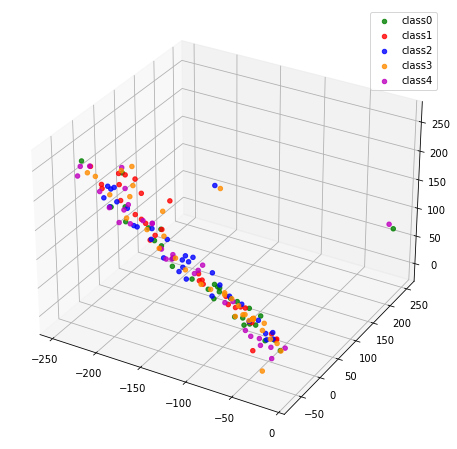

In [87]:
tsneplot3D(X_rep,Y_ae_final,"tsne3dae")

### 3D T-SNE Representation with Downsample

In [90]:
tsne3d1 = TSNE(n_components=3)
X_tsne = tsne3d1.fit_transform(X_ae_final.reshape(len(X_ae_final),-1))

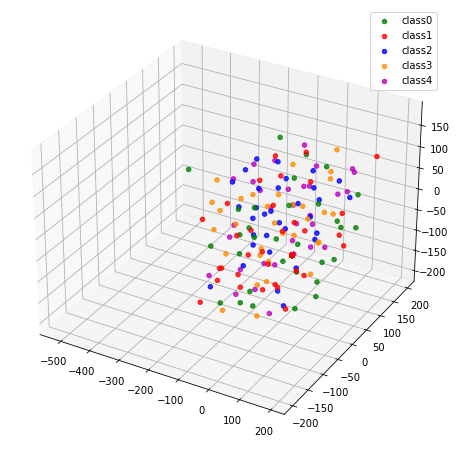

In [91]:
tsneplot3D(X_tsne,Y_ae_final,"tsne3d")

### Conclusion: 

No clusters were found in either 2D or 3D. Perhaps, the training size for multichannel images was not sufficient for the autoencoder to learn the latent representation due to which the images could not be linearly separable in 2D or 3D. 